In [1]:
import numpy as np 
import pandas as pd
import geopandas as gpd

import rasterio
from rasterio.plot import reshape_as_image
from rasterio.features import rasterize

from shapely.geometry import mapping, Point, Polygon
from shapely.ops import unary_union

import matplotlib.pyplot as plt

In [2]:
path = '/home/yurii/.cache/kagglehub/datasets/isaienkov/deforestation-in-ukraine/versions/1'
RASTER_PATH = path + '/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426.SAFE/GRANULE/L1C_T36UYA_A011816_20190611T084501/IMG_DATA/T36UYA_20190611T083609_TCI.jp2'

In [4]:
df = gpd.read_file('/home/yurii/.cache/kagglehub/datasets/isaienkov/deforestation-in-ukraine/versions/1/deforestation_labels.geojson')
df

,img_date,tile,geometry
0,2016-04-09,36UXA,"POLYGON ((35.7913 50.17406, 35.79277 50.17354,..."
1,2016-04-09,36UXA,"POLYGON ((35.77653 50.10271, 35.7781 50.10318,..."
2,2016-04-09,36UXA,"POLYGON ((35.78621 50.01277, 35.78616 50.01369..."
3,2016-04-09,36UXA,"POLYGON ((35.78007 50.00556, 35.78189 50.00557..."
4,2016-04-09,36UXA,"POLYGON ((35.79781 49.99568, 35.79908 49.99582..."
...,...,...,...
5691,2019-09-09,36UYA,"POLYGON ((36.37494 50.17378, 36.37506 50.17376..."
5692,2019-09-09,36UYA,"POLYGON ((36.37849 50.17354, 36.37851 50.17352..."
5693,2019-09-09,36UYA,"POLYGON ((35.91477 50.22407, 35.91472 50.22394..."
5694,2019-10-26,36UYA,"POLYGON ((36.88312 50.26589, 36.88408 50.26489..."


raster bounds: BoundingBox(left=699960.0, bottom=5490240.0, right=809760.0, top=5600040.0)
vector bounds (reprojected): [ 597596.3287418  5480946.93274846  786321.11909311 5605618.82120528]
Does vector bbox intersect raster bbox? True


(np.float64(-0.5), np.float64(10979.5), np.float64(10979.5), np.float64(-0.5))

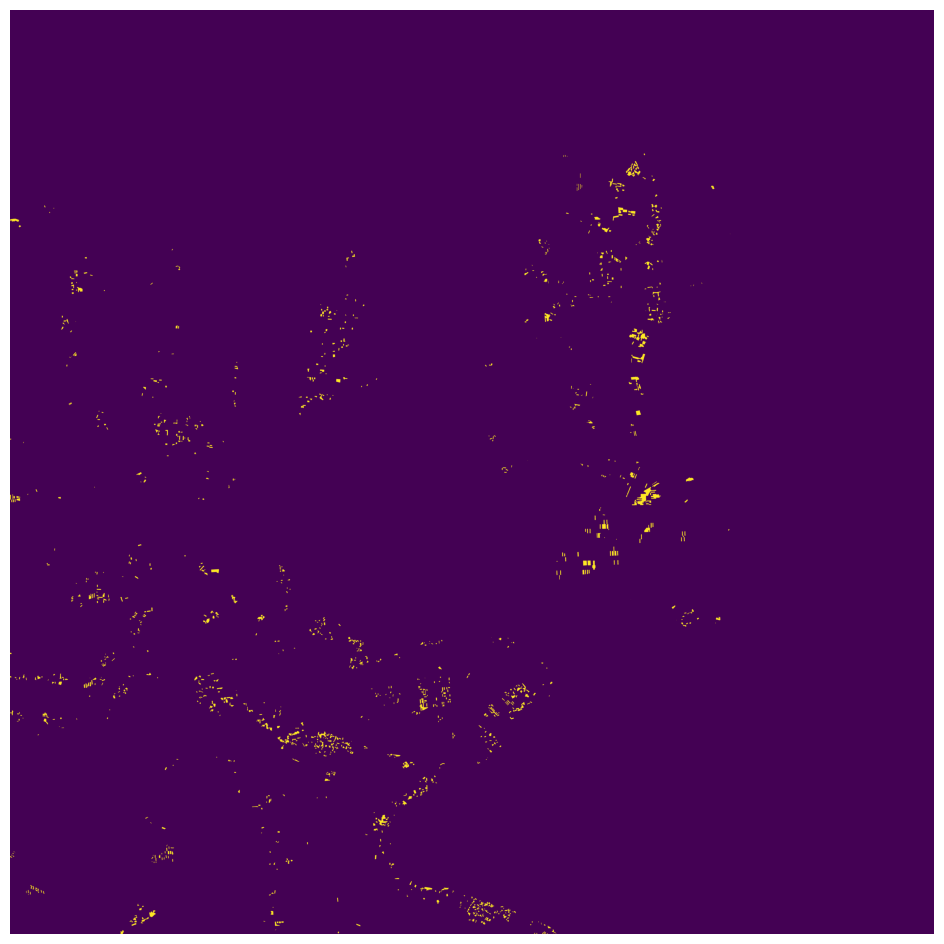

In [5]:
with rasterio.open(RASTER_PATH, "r", driver="JP2OpenJPEG") as src:
    raster_crs = src.crs
    transform = src.transform
    height, width = src.height, src.width
    print("raster bounds:", src.bounds)

# reproject GeoDataFrame into raster CRS (do this AFTER you opened the raster)
df_r = df.to_crs(raster_crs)
print("vector bounds (reprojected):", df_r.total_bounds)

# quick sanity: check overlap
print("Does vector bbox intersect raster bbox?",
      not (df_r.total_bounds[2] < src.bounds.left or df_r.total_bounds[0] > src.bounds.right
           or df_r.total_bounds[3] < src.bounds.bottom or df_r.total_bounds[1] > src.bounds.top))

# prepare shapes in map coordinates and rasterize with the raster's transform
shapes = ((mapping(geom), 1) for geom in df_r.geometry)
mask = rasterize(shapes=shapes, out_shape=(height, width), transform=transform, fill=0, dtype='uint8')

plt.figure(figsize=(12,12))
plt.imshow(mask)
plt.axis('off')